In [2]:
import math
from time import sleep
import numpy as np
import matplotlib.pyplot as plt
import  pandas as pd


In [3]:
import ipyvolume as ipv


In [4]:
import sys
from collections import Counter
from math import comb

In [5]:
from sim.sim.aux  import cache_n_conf, n_conf

In [505]:
import cProfile

pr = cProfile.Profile()

In [6]:
n = 80
dx=10
dy=10
dz=10
caches = cache_n_conf(n, dx+10, dy+10, dz+10)
caches.shape

(80, 20, 20, 20)

# Uniform regrow

In [103]:
def regrow(n, dx,dy,dz, res):
    """
    recursive uniform regrow.
    The generated coordinates are random
    """
    
    if n ==1:
        return res + [[0,0,0]]
    else:
        neighbours = [[n-1, dx-1, dy, dz],
                      [n-1, dx+1, dy, dz],
                      [n-1, dx, dy-1, dz],
                      [n-1, dx, dy+1, dz],
                      [n-1, dx, dy, dz-1],
                      [n-1, dx, dy, dz+1]
                     ]
        counts= []
        for n_ in neighbours:
            counts.append(caches[n_[0] -1, abs(n_[1]), abs(n_[2]), abs(n_[3])])
        
        # normalising
        counts = [c/sum(counts) for c in counts]
        # uniform sampling
#         nonzeros = [v for v in counts if v>0]
#         counts = [1/len(nonzeros) if c !=0 else c for c in counts]
        # wrong sampling
#         counts = [1/6. for i in range(6)]

#         print(counts)

        # making cumulative sum
        counts_ = np.cumsum(counts)
        if sum(counts_) == 0:
            print('failed to grow')
            sys.exit()
        #selecting one of neigbours
        selected =  np.argmax(counts_ > np.random.rand())
#         print(neighbours[selected])
        res.append(neighbours[selected][1:])
#         print(c)
#         print('res', res)   
#         sel.append(selected)
        
#         nz.append(counts[selected])


        return regrow(*neighbours[selected],    res)
#         sys.exit()
                    

In [668]:
def regrow_biased(n, dx,dy,dz, res, w,alpha, k):
    """
    recursive biased regrow.
    The generated coordinates are biased
    """
    
#     alpha = .1 # amplitude for the number of coordinate cooincidence.
    
    if n ==1:
        return res + [(0,0,0)], w, k
    else:
        neighbours = [[n-1, dx-1, dy, dz],
                      [n-1, dx+1, dy, dz],
                      [n-1, dx, dy-1, dz],
                      [n-1, dx, dy+1, dz],
                      [n-1, dx, dy, dz-1],
                      [n-1, dx, dy, dz+1]
                     ]
        counts= []
        tmp = 0
        all_coincidence = []
        for neighbour in neighbours:
            # calculating number of coordinate coincidence  for the  grown part of the coords 
            coords = res+[tuple(neighbour[1:]) , (0,0,0)] # adding a trial position
            c = Counter(coords).values()
            
#             coords = np.array(res+[neighbour[1:] , [0,0,0]]) # adding a trial position
#             u, c = np.unique(coords, axis=0, return_counts=True)
            # number of coincidential coords (NOT the number of pair-wise intersections)
#             n_coincide = sum([el for el in c if  el>1])
            n_coincide = sum([comb(v,2) for v in c])/len(coords)
            all_coincidence.append(n_coincide)
#             print(coords, n_coincide)
            count = caches[neighbour[0] -1, abs(neighbour[1]), abs(neighbour[2]), abs(neighbour[3])]
            counts.append(np.exp(-alpha*n_coincide)* count )
            tmp += count # accumulating the denominator
#             print(count, np.exp(-alpha*n_coincide))
                          
#         print(10*'dd')
        # calculating W
        w = w*sum(counts)/tmp
#         print(w)
        # normalising p_i
        counts = [c/sum(counts) for c in counts]
        
        # making cumulative sum
        counts_ = np.cumsum(counts)
        if sum(counts_) == 0:
            print('failed to grow')
            sys.exit()
        #selecting one of neigbours
        selected =  np.argmax(counts_ > np.random.rand())
#         print(neighbours[selected])
        res.append(tuple(neighbours[selected][1:]))
#         print(c)
#         print('res', res)   
#         sel.append(selected)
        
#         nz.append(counts[selected])
#         print(all_coincidence[selected])
        k +=  all_coincidence[selected]
#         print(len(res), all_coincidence[selected])
        return regrow_biased(*neighbours[selected],    res, w, alpha, k)
#         sys.exit()
                    

In [529]:
pr.enable()
for i in range(10000):
    coords, w, out = regrow_biased(10, 0,0,0, res=[], w=1, alpha=1.0, k=0)
pr.disable()
pr.print_stats(sort="cumtime")

         81567044 function calls (77720714 primitive calls) in 92.685 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       12    0.000    0.000   95.403    7.950 interactiveshell.py:3400(run_code)
       12    0.000    0.000   95.403    7.950 {built-in method builtins.exec}
110100/11010    7.509    0.000   76.337    0.007 464747923.py:1(regrow_biased)
4899960/1332720    5.916    0.000   64.204    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
   594540    0.736    0.000   59.772    0.000 <__array_function__ internals>:2(unique)
   594540    4.338    0.000   58.065    0.000 arraysetops.py:138(unique)
   594540    9.259    0.000   22.801    0.000 arraysetops.py:320(_unique1d)
  1189080    0.882    0.000   15.252    0.000 <__array_function__ internals>:2(moveaxis)
  1189080    4.480    0.000   13.309    0.000 numeric.py:1398(moveaxis)
   594540    1.393    0.000   10.759    0.000 arraysetops.

In [555]:
%timeit bins11, counts_11, out = URW_biased(n=n, n_steps=100, alpha=.10)

0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
676 ms ± 8.32 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [562]:
%timeit bins11, counts_11, out = URW_biased(n=n, n_steps=100, alpha=.10)

0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
651 ms ± 17.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [523]:
%timeit u,c= np.unique(np.random.rand(100,3), axis=0, return_counts=True)


90.8 µs ± 2.45 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [550]:
%timeit coords, w, out = regrow_biased(10, 0,0,0, res=[], w=1, alpha=1.0, k=0)

466 µs ± 21.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [504]:
%timeit coords = regrow(10, 0,0,0, res=[])

197 µs ± 21.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [341]:
np.exp(-.2)

0.8187307530779818

In [664]:
alpha = 50.
for i in range(10):
    coords, w, k = regrow_biased(30, 0,0,0, res=[], w=1, alpha=alpha,  k=0)
#     u, c = np.unique(np.array(coords), axis=0, return_counts=True)
    # number of coincidential coords (NOT the number of pair-wise intersections)
#     n_coincide = sum([el for el in c if  el>1])
    # coords, n_coincide, u, c,  w
#     print(k, n_coincide, np.exp(-alpha*k)/w, w)
    print(k)

1 0.0
2 0.0
3 0.0
4 0.0
5 0.0
6 0.0
7 0.0
8 0.0
9 0.0
10 0.0
11 0.0
12 0.0
13 0.0
14 0.0
15 0.0
16 0.0
17 0.0
18 0.0
19 0.0
20 0.0
21 0.0
22 0.0
23 0.0
24 0.0
25 0.0
26 0.0
27 0.0
28 0.034482758620689655
29 0.06666666666666667
0.10114942528735632
1 0.0
2 0.0
3 0.0
4 0.0
5 0.0
6 0.0
7 0.0
8 0.0
9 0.0
10 0.0
11 0.0
12 0.0
13 0.0
14 0.0
15 0.0
16 0.0
17 0.0
18 0.0
19 0.0
20 0.0
21 0.0
22 0.043478260869565216
23 0.041666666666666664
24 0.04
25 0.038461538461538464
26 0.07407407407407407
27 0.10714285714285714
28 0.13793103448275862
29 0.16666666666666666
0.6494210983641269
1 0.0
2 0.0
3 0.0
4 0.0
5 0.0
6 0.0
7 0.0
8 0.0
9 0.0
10 0.0
11 0.0
12 0.0
13 0.0
14 0.0
15 0.0
16 0.0
17 0.0
18 0.0
19 0.0
20 0.0
21 0.0
22 0.0
23 0.0
24 0.0
25 0.0
26 0.0
27 0.0
28 0.0
29 0.0
0.0
1 0.0
2 0.0
3 0.0
4 0.0
5 0.0
6 0.0
7 0.0
8 0.0
9 0.0
10 0.0
11 0.0
12 0.0
13 0.0
14 0.0
15 0.0
16 0.0
17 0.0
18 0.0
19 0.0
20 0.0
21 0.0
22 0.0
23 0.0
24 0.0
25 0.038461538461538464
26 0.037037037037037035
27 0.03571428571428

# biased RW

In [679]:
def URW_biased(n, n_steps, alpha):
    
    intersections = []
    c_old, w_o, k_o = regrow_biased(n, 0,0,0, [], w=1,alpha=alpha, k=0)
    c_old = np.array(c_old).astype(float)
    u, c_o = np.unique(c_old, axis=0, return_counts=True)
#     n_coincide_old = sum([el for el in c_o if  el>1])
    acceptance_rate = 0
    out = []
    for i in range(1,n_steps):
        if  i%1000 ==0: print(i/n_steps*100, '%', 'acceptance rate: %2.2f'%(acceptance_rate*100/i))
        c_new, w_n, k_n = regrow_biased(n, 0,0,0, [], w=1, alpha=alpha, k=0)
        
#         coords = res+[tuple(neighbour[1:]) , (0,0,0)] # adding a trial position
        c_n = Counter(c_new).values()
        if (sum([comb(v,2) for v in c_n]) == 0):
            print('SAW', w_n/w_o * np.exp(-alpha*(k_o - k_n)), w_n/w_o)
#         c_new = np.array(c_new).astype(float)
#         u, c_n = np.unique(c_new, axis=0, return_counts=True)

#         print(coords, coords.shape, "\n")
#         sys.exit()
    #     scatter1.x = lines1.x = coords[0,:]
    #     scatter1.y = lines1.y = coords[1,:]
    #     scatter1.z = lines1.z = coords[2,:]
    #     sleep(.2)
#         if not np.sum(np.abs(np.diff(c_new, axis=0))) == c_new.shape[0]-1:
#             print('failed  to build')
#             print(coords, "\n")
#             sys.exit()
    #     print(coords.T)
#         n_coincide_new = sum([el for el in c_n if  el>1])
        if np.random.rand() < (w_n/w_o) * np.exp(-alpha*(k_o - k_n)):
            out.append((k_n-k_o , (w_n/w_o) * np.exp(-alpha*(k_o - k_n))))
            c_o = c_n#.copy()
            w_o = w_n
            k_o = k_n
            acceptance_rate+=1
          
        intersections.append(sum([comb(v,2) for v in c_o]))

    bins, counts_= np.unique(intersections, return_counts=True)
    counts_ = [c/sum(counts_) for c in counts_]
    
    return bins, counts_, out

In [442]:
n_steps = 5000
n = 10
bins11, counts_11, out = URW_biased(n=n, n_steps=n_steps, alpha=.10)
# bins, counts_ = URW(n=n, n_steps=n_steps)

0.0 %
2.0 %
4.0 %
6.0 %
8.0 %
10.0 %
12.0 %
14.000000000000002 %
16.0 %
18.0 %
20.0 %
22.0 %
24.0 %
26.0 %
28.000000000000004 %
30.0 %
32.0 %
34.0 %
36.0 %
38.0 %
40.0 %
42.0 %
44.0 %
46.0 %
48.0 %
50.0 %
52.0 %
54.0 %
56.00000000000001 %
57.99999999999999 %
60.0 %
62.0 %
64.0 %
66.0 %
68.0 %
70.0 %
72.0 %
74.0 %
76.0 %
78.0 %
80.0 %
82.0 %
84.0 %
86.0 %
88.0 %
90.0 %
92.0 %
94.0 %
96.0 %
98.0 %


In [443]:
a,b = zip(*out)
np.corrcoef(a,b)


array([[1.        , 0.87688888],
       [0.87688888, 1.        ]])

In [243]:
fig = ipv.figure()
c_ = np.array(coords).T.astype('float') 
lines1 = ipv.plot(c_[0,:], c_[1, :], c_[2, :], color='red',)
scatter1 = ipv.scatter(c_[0,:], c_[1, :], c_[2, :], color='red',  marker='sphere', size=4)

ipv.pylab.xlim(-4,4)
ipv.pylab.ylim(-4,4)
ipv.pylab.zlim(-4,4)
ipv.show()

In [96]:
# ss = []
# for i in range(10):
#     chain, nonzeros = regrow(10, 0,0,0, [], [])
#     ss.append(nonzeros)
    
# # Counter([el for   sub in ss for  el in sub ])
# [np.prod(el) for el in ss]

In [11]:
# bins, counts_ = URW(n=12, n_steps=100000)

In [406]:
from sim.sim.overlaps import  Overlap
overlaps = Overlap(20)

t = overlaps.get_overlaps_histogram()
6/sum(t.values()), print(overlaps), 6./32496156

KeyboardInterrupt: 

In [13]:

t = dict(zip(t.keys(), 
                         [v/sum(t.values()) for v in t.values()]))

plt.figure(figsize=(12,8))
# plt.bar(t.keys(), t.values(), alpha=0.5, label = 'exact')
# plt.hist(intersections, density=True, facecolor='red', alpha=0.5, bins=30)
plt.scatter(bins, counts_,facecolor='red', alpha=0.5, label='URW', marker='x', s=150)
plt.yscale('log')
plt.scatter(t.keys(), t.values(), label = 'exact', marker='o', s=40)
plt.legend()
plt.title('1 million confs')

NameError: name 'bins' is not defined

<Figure size 864x576 with 0 Axes>

# WL procedure

In [715]:
def WL(n, max_overlaps, exclude,alpha=0):
    """
    WL  procedure for calculation of overlapping entropy
    """
    counts = np.zeros(max_overlaps)
    s = np.zeros(max_overlaps)
    ds_min = 0.001
    ds = 1

    o_=1
    w_o=1
    k_o=0
    collect_s = []
    sweep_number = 0
    
    indexes = [ind for ind in range(max_overlaps) if ind not in exclude] 

    while ds>ds_min:
        sweep_number +=1
        print('sweeping', sweep_number)
        for i in range(1000):

#             coords_n = regrow(n, 0,0,0, [])
            coords_n, w_n, k_n = regrow_biased(n, 0,0,0, [], w=1, alpha=alpha, k=0)
            
            coords_n = np.array(coords_n)
            u, c = np.unique(coords_n, axis=0, return_counts=True)
            n_ = sum([comb(v,2) for v in c])
             
            if (n_ < max_overlaps):
                
                if np.random.rand() < (w_n/w_o) * np.exp(-alpha*(k_o - k_n))* np.exp(s[o_] - s[n_]):
#                     out.append((k_n-k_o , (w_n/w_o) * np.exp(-alpha*(k_o - k_n))))
#                     c_o = c_n#.copy()
                    w_o = w_n
                    k_o = k_n
            
#                 if  (np.random.rand() < np.exp(s[o_] - s[n_])) :
        #             print('pass')

                    o_ = n_


            counts[o_] += 1
            s[o_] += ds
#             print(o_)

        t = counts[indexes]
        print(counts)

#         t = counts[counts>0]
    #     print(t)
        mean = sum(t)/len(t)
    #     print(max(t)/mean -1, 1- min(t)/mean )
        if (max(t)/mean -1 < .3)& ( 1- min(t)/mean <.3):
            print(counts)
            counts = 0*counts
            print(repr(s))
            collect_s.append(s.copy())
            ds = ds/2
            print(ds)
            
    return collect_s


# URW

In [301]:
def URW(n, n_steps):
    
    intersections = []
    for i in range(n_steps):
        if  i%10000 ==0: print(i/n_steps*100, '%')
        coords = regrow(n, 0,0,0, [])
        coords = np.array(coords).T.astype(float)
#         print(coords, coords.shape, "\n")
#         sys.exit()
    #     scatter1.x = lines1.x = coords[0,:]
    #     scatter1.y = lines1.y = coords[1,:]
    #     scatter1.z = lines1.z = coords[2,:]
    #     sleep(.2)
#         if not np.sum(np.abs(np.diff(coords, axis=1))) == coords.shape[1]-1:
#             print('failed  to build')
#             print(coords, "\n")
#             sys.exit()
    #     print(coords.T)
        u, c = np.unique(coords.T, axis=0, return_counts=True)
    #     print(u,c)
        intersections.append(sum([comb(v,2) for v in c]))

    bins, counts_= np.unique(intersections, return_counts=True)
    counts_ = [c/sum(counts_) for c in counts_]
    
    return bins, counts_

In [30]:
def get_regrown_coords(n, coords):
    """
    regrows not whole chain, bun  a piece of it
    """
    
     # selecting two points
#     a = np.random.randint(n)  # [0,n)
#     b = (a + np.random.randint(1,n))%n
    a = 0; b=n-1
        # calculating coordinate deltas 
    dx, dy, dz = abs(coords[:, b] - coords[:,a]).astype(int)
#         print(a,b, dx,dy,dz)
#         sys.exit()
        # regrowing part of the chain
    coords_partly = regrow(abs(b-a), dx, dy, dz, [[dx,dy,dz]])

#     print(abs(a-b), len(coords_partly))
        # regrowing goes from back to the beginning. 
        # It means that the last element will be at [0,0,0]
    coords_partly = np.array(coords_partly).T.astype(float)
#         print("regrown orientation, must be positive", coords_partly[:, -1] - coords_partly[:, 0])
#         print(coords_partly)
#         print(np.flip(coords_partly, axis=1))
        #  reorientation
    for j in range(3):
            if coords[j, b] - coords[j, a] <0:
                coords_partly[j, :] = - coords_partly[j, :]
#         print("coords_partly\n", coords_partly)
#         print('old orientations:', coords[:,b] - coords[:,a],'new:', coords_partly[:,-1]- coords_partly[:,0])
    if a<b:
            coords[:, a:b+1] = np.flip(coords_partly, axis=1) +  coords[:, a:a+1]
    else:
            coords[:, b:a+1] = coords_partly + coords[:, a:a+1]
    return coords

In [17]:
def URW_partly(n, n_steps):
    
    intersections = []
    coords = regrow(n, 0,0,0, [])
    coords = np.array(coords).T.astype(float)
    
    for i in range(n_steps):
        if  i%10000 ==0: print(i/n_steps*100, '%')
            
       
        coords = get_regrown_coords(n, coords)
#         print(coords[:, a-1], coords[:, a], coords[:, a+1])
#         print(coords[:, b-1], coords[:, b], coords[:, b+1])

    #     print(coords.T)
#         scatter1.x = lines1.x = coords[0,:]
#         scatter1.y = lines1.y = coords[1,:]
#         scatter1.z = lines1.z = coords[2,:]
#         sleep(.1)
        if not np.sum(np.abs(np.diff(coords, axis=1))) == coords.shape[1]-1:
        
#             print(a,b)
            print(coords, "\n")
            sys.exit()
        u, c = np.unique(coords.T, axis=0, return_counts=True)
    #     print(u,c)
        intersections.append(sum([comb(v,2) for v in c]))

    bins, counts_= np.unique(intersections, return_counts=True)
    counts_ = [c/sum(counts_) for c in counts_]
    
    return bins, counts_

In [18]:
def WL_partly(n, max_overlaps, exclude):
    """
    WL  procedure for calculation of overlapping entropy
    """
    counts = np.zeros(max_overlaps)
    s = np.zeros(max_overlaps)
    ds_min = 0.0001
    ds = 1.

    o_=10
    collect_s = []
    sweep_number = 0
    
    
    coords_o = regrow(n, 0,0,0, [])
    coords_o = np.array(coords_o).T.astype(float)
    u, c = np.unique(coords_o, axis=1, return_counts=True)
    o_ = sum([comb(v,2) for v in c])
    
    indexes = [ind for ind in range(max_overlaps) if ind not in exclude] 
    
    while ds>ds_min:
        sweep_number +=1
        print('sweeping', sweep_number)
        for i in range(10000):

            coords_n = get_regrown_coords(n, coords_o)
            
            if not np.sum(np.abs(np.diff(coords_n, axis=1))) == coords_n.shape[1]-1:
        
#                 print(a,b)
                print(coords_n, "\n")
                sys.exit()
            
#             print(coords_n, "\n")
            u, c = np.unique(coords_n, axis=1, return_counts=True)
            n_ = sum([comb(v,2) for v in c])
             
            if (n_ < max_overlaps):
                if  (np.random.rand() < np.exp(s[o_] - s[n_])) :
        #             print('pass')
#                     print('o, n', o_, n_, np.exp(s[o_] - s[n_]))
                    o_ = n_
                    coords_o = coords_n.copy()
#                 else:
#                     print('not pass to ', n_, np.exp(s[o_] - s[n_]))

            counts[o_] += 1
#             print(counts)
            s[o_] += ds
#             print(o_)
        print(counts)
        t = counts[indexes]
#         t = counts[counts>0]
    #     print(t)
        mean = sum(t)/len(t)
    #     print(max(t)/mean -1, 1- min(t)/mean )
        if (max(t)/mean -1 < .3)& ( 1- min(t)/mean <.3):
            print(30*'@@')
            counts = 0*counts
            print(s)
            collect_s.append(s.copy())
            ds = ds/2
            print(ds)
            
    return collect_s


In [445]:
n_steps = 5000
n = 10
bins, counts_ = URW(n=n, n_steps=n_steps)
# bins, counts_ = URW(n=n, n_steps=n_steps)

0.0 %


In [35]:
# collect_s_partly = WL_partly(n=n, max_overlaps = 20,  exclude=(23,24,26,27,28,29))
collect_s = WL(n=n, max_overlaps = 21, exclude=(15,17,18,19))

sweeping 1
sweeping 2
sweeping 3


/var/folders/zr/t79_wh252w1d3vc6snt72_lh0000gn/T/ipykernel_24509/2194508741.py:27: RuntimeWarning: overflow encountered in exp
  if  (np.random.rand() < np.exp(s[o_] - s[n_])) :


sweeping 4
sweeping 5
sweeping 6
sweeping 7
sweeping 8
sweeping 9
sweeping 10
sweeping 11
sweeping 12
sweeping 13
sweeping 14
sweeping 15
sweeping 16
sweeping 17
sweeping 18
sweeping 19
[11202. 11209. 11208. 11209. 11207. 11209. 11210. 11204. 11206. 11199.
 11202. 11192. 11203. 11110. 11189.     0. 11117.     0.     0.     0.
 10924.]
[11202. 11209. 11208. 11209. 11207. 11209. 11210. 11204. 11206. 11199.
 11202. 11192. 11203. 11110. 11189.     0. 11117.     0.     0.     0.
 10924.]
0.5
sweeping 20
sweeping 21
sweeping 22
sweeping 23
sweeping 24
sweeping 25
sweeping 26
sweeping 27
sweeping 28
sweeping 29
sweeping 30
sweeping 31
sweeping 32
sweeping 33
sweeping 34
sweeping 35
sweeping 36
sweeping 37
sweeping 38
sweeping 39
sweeping 40
sweeping 41
sweeping 42
sweeping 43
sweeping 44
sweeping 45
sweeping 46
sweeping 47
sweeping 48
sweeping 49
sweeping 50
sweeping 51
sweeping 52
sweeping 53
sweeping 54
sweeping 55
[21162. 21153. 21154. 21154. 21157. 21154. 21146. 21158. 21154. 21167.
 2115

sweeping 409
sweeping 410
sweeping 411
sweeping 412
sweeping 413
sweeping 414
sweeping 415
sweeping 416
sweeping 417
sweeping 418
sweeping 419
sweeping 420
sweeping 421
sweeping 422
sweeping 423
sweeping 424
sweeping 425
sweeping 426
sweeping 427
sweeping 428
sweeping 429
sweeping 430
sweeping 431
sweeping 432
sweeping 433
sweeping 434
sweeping 435
sweeping 436
sweeping 437
sweeping 438
sweeping 439
sweeping 440
sweeping 441
sweeping 442
sweeping 443
sweeping 444
sweeping 445
sweeping 446
sweeping 447
sweeping 448
sweeping 449
sweeping 450
sweeping 451
sweeping 452
sweeping 453
sweeping 454
sweeping 455
sweeping 456
sweeping 457
sweeping 458
sweeping 459
sweeping 460
sweeping 461
sweeping 462
sweeping 463
sweeping 464
sweeping 465
sweeping 466
sweeping 467
sweeping 468
sweeping 469
sweeping 470
sweeping 471
sweeping 472
sweeping 473
sweeping 474
sweeping 475
sweeping 476
sweeping 477
sweeping 478
sweeping 479
sweeping 480
sweeping 481
sweeping 482
[75682. 75604. 75642. 75619. 75622. 75

sweeping 857
sweeping 858
sweeping 859
sweeping 860
sweeping 861
sweeping 862
sweeping 863
sweeping 864
sweeping 865
sweeping 866
sweeping 867
sweeping 868
sweeping 869
sweeping 870
sweeping 871
sweeping 872
sweeping 873
sweeping 874
sweeping 875
sweeping 876
sweeping 877
sweeping 878
sweeping 879
sweeping 880
sweeping 881
sweeping 882
sweeping 883
sweeping 884
sweeping 885
sweeping 886
sweeping 887
sweeping 888
sweeping 889
sweeping 890
sweeping 891
sweeping 892
sweeping 893
sweeping 894
sweeping 895
sweeping 896
sweeping 897
sweeping 898
sweeping 899
sweeping 900
sweeping 901
sweeping 902
sweeping 903
sweeping 904
sweeping 905
sweeping 906
sweeping 907
sweeping 908
sweeping 909
sweeping 910
sweeping 911
sweeping 912
sweeping 913
sweeping 914
sweeping 915
sweeping 916
sweeping 917
sweeping 918
sweeping 919
sweeping 920
sweeping 921
sweeping 922
sweeping 923
sweeping 924
sweeping 925
sweeping 926
sweeping 927
sweeping 928
sweeping 929
sweeping 930
sweeping 931
sweeping 932
sweeping 933

Text(0, 0.5, 'fraction of conformations')

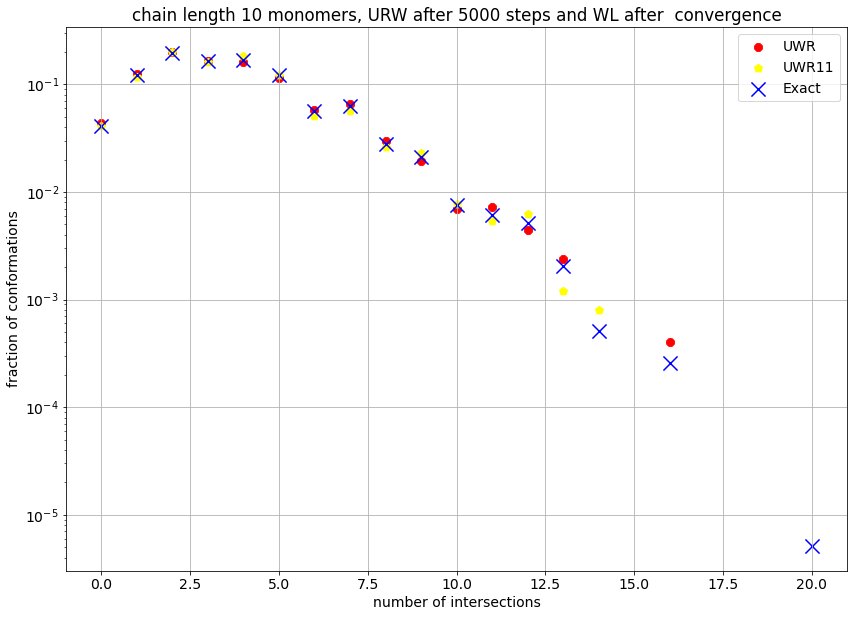

In [446]:
plt.figure(figsize=(14,10), )
plt.rc('font', size=14)
plt.scatter(bins, counts_,facecolor='red', marker='8', label='UWR', s=70)
plt.scatter(bins11, counts_11,facecolor='yellow', marker='p', label='UWR11', s=70)

# s = collect_s[-1]
# ttt = np.exp(s - max(s));  ttt = [v  if v>10**(-10) else 0 for v in ttt]
# t_ = [v/sum(ttt) for v in ttt]
# plt.scatter(np.arange(21), t_, facecolor='black', marker='.',s=50, label='WL')
    
    

t = dict(zip(t.keys(), 
                         [v/sum(t.values()) for v in t.values()]))

plt.scatter(t.keys(), t.values(), facecolor='blue', marker='x', label='Exact', s=200)
 # plt.hist(intersections, density=True, facecolor='red', alpha=0.5, bins=30)
plt.yscale('log')
plt.grid()
plt.legend()
plt.title('chain length %i monomers, URW after %i steps and WL after  convergence' %(n, n_steps))
plt.xlabel('number of intersections')
plt.ylabel('fraction of conformations')

In [240]:
collect_s = WL(n=12, max_overlaps = 30)

sweeping 1
sweeping 2
sweeping 3
sweeping 4
sweeping 5
[2286. 2423. 2493. 2484. 2501. 2484. 2448. 2426. 2389. 2326. 2316. 2129.
 2243. 2135. 2196.    0. 2095. 1950. 1823. 1787. 1786. 1945. 1724.    0.
    0. 1611.    0.    0.    0.    0.]
[22.86 24.23 24.93 24.84 25.01 24.84 24.48 24.26 23.89 23.26 23.16 21.29
 22.43 21.35 21.96  0.   20.95 19.5  18.23 17.87 17.86 19.45 17.24  0.
  0.   16.11  0.    0.    0.    0.  ]
0.005
sweeping 6
sweeping 7
sweeping 8
sweeping 9
sweeping 10
sweeping 11
sweeping 12
[3118. 3110. 3120. 3127. 3100. 3132. 3084. 3107. 3111. 3121. 3142. 3235.
 3153. 3229. 3046. 4324. 3172. 3227. 3210. 3401. 3062. 2669.    0.    0.
    0.    0.    0.    0.    0.    0.]
[38.45  39.78  40.53  40.475 40.51  40.5   39.9   39.795 39.445 38.865
 38.87  37.465 38.195 37.495 37.19  21.62  36.81  35.635 34.28  34.875
 33.17  32.795 17.24   0.     0.    16.11   0.     0.     0.     0.   ]
0.0025
sweeping 13
sweeping 14
sweeping 15
sweeping 16
sweeping 17
sweeping 18
sweeping 19
swee

In [285]:
bins, counts_ = URW(n=12, n_steps=1000000)

0.0 %
1.0 %
2.0 %
3.0 %
4.0 %
5.0 %
6.0 %
7.000000000000001 %
8.0 %
9.0 %
10.0 %
11.0 %
12.0 %
13.0 %
14.000000000000002 %
15.0 %
16.0 %
17.0 %
18.0 %
19.0 %
20.0 %
21.0 %
22.0 %
23.0 %
24.0 %
25.0 %
26.0 %
27.0 %
28.000000000000004 %
28.999999999999996 %
30.0 %
31.0 %
32.0 %
33.0 %
34.0 %
35.0 %
36.0 %
37.0 %
38.0 %
39.0 %
40.0 %
41.0 %
42.0 %
43.0 %
44.0 %
45.0 %
46.0 %
47.0 %
48.0 %
49.0 %
50.0 %
51.0 %
52.0 %
53.0 %
54.0 %
55.00000000000001 %
56.00000000000001 %
56.99999999999999 %
57.99999999999999 %
59.0 %
60.0 %
61.0 %
62.0 %
63.0 %
64.0 %
65.0 %
66.0 %
67.0 %
68.0 %
69.0 %
70.0 %
71.0 %
72.0 %
73.0 %
74.0 %
75.0 %
76.0 %
77.0 %
78.0 %
79.0 %
80.0 %
81.0 %
82.0 %
83.0 %
84.0 %
85.0 %
86.0 %
87.0 %
88.0 %
89.0 %
90.0 %
91.0 %
92.0 %
93.0 %
94.0 %
95.0 %
96.0 %
97.0 %
98.0 %
99.0 %


[69.953125   71.2040625  71.80625    71.85796875 71.868125   71.786875
 71.35296875 71.1634375  70.91453125 70.338125   70.27921875 69.025
 69.493125   68.97046875 68.465625   62.7271875  67.84765625 67.16203125
 66.2040625  65.880625   64.5028125  64.88359375 61.9503125   0.
  0.         60.9878125   0.          0.          0.          0.        ]


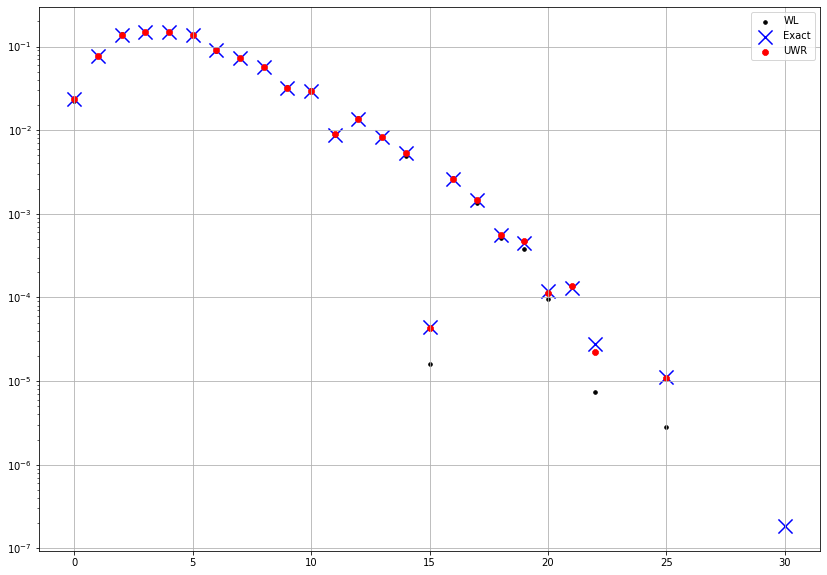

In [286]:
plt.figure(figsize=(14,10))

for s in collect_s[-1:]:
#     plt.plot(np.exp(s - max(s)))
    ttt = np.exp(s - max(s));  ttt = [v  if v>10**(-30) else 0 for v in ttt]
    t_ = [v/sum(ttt) for v in ttt]
    plt.scatter(np.arange(30), t_, facecolor='black', marker='.',s=50, label='WL')
    print(s)
    plt.scatter(t.keys(), t.values(), facecolor='blue', marker='x', label='Exact', s=200)
    # plt.hist(intersections, density=True, facecolor='red', alpha=0.5, bins=30)
    plt.scatter(bins, counts_,facecolor='red', marker='8', label='UWR')
    plt.yscale('log')
    plt.grid()
    plt.legend()


#  the same for n=20

In [563]:
n =20
n_steps = 10000
bins11_20, counts_11_20, out = URW_biased(n=n, n_steps=n_steps, alpha=.10)
# bins_20, counts_20 = URW(n=n, n_steps=n_steps)


0.0 %
1.0 %
2.0 %
3.0 %
4.0 %
5.0 %
6.0 %
7.000000000000001 %
8.0 %
9.0 %
10.0 %
11.0 %
12.0 %
13.0 %
14.000000000000002 %
15.0 %
16.0 %
17.0 %
18.0 %
19.0 %
20.0 %
21.0 %
22.0 %
23.0 %
24.0 %
25.0 %
26.0 %
27.0 %
28.000000000000004 %
28.999999999999996 %
30.0 %
31.0 %
32.0 %
33.0 %
34.0 %
35.0 %
36.0 %
37.0 %
38.0 %
39.0 %
40.0 %
41.0 %
42.0 %
43.0 %
44.0 %
45.0 %
46.0 %
47.0 %
48.0 %
49.0 %
50.0 %
51.0 %
52.0 %
53.0 %
54.0 %
55.00000000000001 %
56.00000000000001 %
56.99999999999999 %
57.99999999999999 %
59.0 %
60.0 %
61.0 %
62.0 %
63.0 %
64.0 %
65.0 %
66.0 %
67.0 %
68.0 %
69.0 %
70.0 %
71.0 %
72.0 %
73.0 %
74.0 %
75.0 %
76.0 %
77.0 %
78.0 %
79.0 %
80.0 %
81.0 %
82.0 %
83.0 %
84.0 %
85.0 %
86.0 %
87.0 %
88.0 %
89.0 %
90.0 %
91.0 %
92.0 %
93.0 %
94.0 %
95.0 %
96.0 %
97.0 %
98.0 %
99.0 %


In [472]:
bins

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 39, 40, 42, 45])

In [454]:
a,b = zip(*out)
np.corrcoef(a,b)

array([[1.        , 0.81121429],
       [0.81121429, 1.        ]])

In [417]:
collect_s = WL(n=20, max_overlaps = 40, exclude=())

sweeping 1
[301. 297. 304. 307. 306. 309. 309. 307. 310. 307. 307. 307. 305. 304.
 306. 304. 307. 302. 301. 307. 302. 304. 305. 303. 303. 271. 275. 297.
 281. 225.   0. 267. 128. 197.   0. 253. 182.   0.   0.   0.]
sweeping 2
[548. 547. 555. 555. 558. 554. 558. 556. 555. 556. 554. 553. 556. 552.
 549. 552. 551. 550. 550. 539. 551. 552. 531. 545. 542. 549. 548. 503.
 547. 538. 479. 340. 501. 500. 397. 348. 182. 465. 334.   0.]
sweeping 3
[780. 786. 785. 787. 785. 789. 788. 788. 787. 787. 783. 787. 788. 784.
 785. 784. 782. 783. 782. 785. 784. 784. 779. 779. 762. 785. 690. 730.
 743. 759. 728. 731. 639. 675. 651. 699. 625. 752. 548. 652.]
[780. 786. 785. 787. 785. 789. 788. 788. 787. 787. 783. 787. 788. 784.
 785. 784. 782. 783. 782. 785. 784. 784. 779. 779. 762. 785. 690. 730.
 743. 759. 728. 731. 639. 675. 651. 699. 625. 752. 548. 652.]
array([780., 786., 785., 787., 785., 789., 788., 788., 787., 787., 783.,
       787., 788., 784., 785., 784., 782., 783., 782., 785., 784., 784.,
     

[2014. 1966. 1989. 1982. 1985. 1975. 1983. 1980. 1975. 1972. 1985. 1979.
 1983. 1987. 1976. 1969. 1984. 1978. 1993. 1979. 1986. 1966. 1988. 2019.
 2008. 2038. 2007. 1960. 2034. 1996. 1796. 1947. 2248. 2197. 1850. 2078.
 1705. 2044. 1584. 2915.]
sweeping 29
[2250. 2215. 2239. 2232. 2239. 2227. 2235. 2229. 2223. 2223. 2234. 2227.
 2231. 2229. 2229. 2225. 2239. 2214. 2238. 2226. 2228. 2210. 2222. 2251.
 2261. 2296. 2253. 2221. 2267. 2266. 2163. 2188. 2549. 2377. 2237. 2078.
 2276. 2554. 1584. 2915.]
[2250. 2215. 2239. 2232. 2239. 2227. 2235. 2229. 2223. 2223. 2234. 2227.
 2231. 2229. 2229. 2225. 2239. 2214. 2238. 2226. 2228. 2210. 2222. 2251.
 2261. 2296. 2253. 2221. 2267. 2266. 2163. 2188. 2549. 2377. 2237. 2078.
 2276. 2554. 1584. 2915.]
array([2473.75 , 2476.375, 2477.625, 2478.25 , 2479.125, 2478.625,
       2479.125, 2478.875, 2478.625, 2478.375, 2478.75 , 2478.375,
       2477.625, 2477.375, 2478.625, 2477.375, 2476.875, 2475.75 ,
       2476.5  , 2474.5  , 2475.5  , 2473.75 , 2473.

[2279. 2305. 2277. 2276. 2274. 2277. 2276. 2283. 2288. 2285. 2281. 2271.
 2282. 2283. 2264. 2280. 2279. 2257. 2260. 2264. 2258. 2288. 2252. 2300.
 2278. 2299. 2214. 2291. 2207. 2355. 2353. 2297. 2459. 2371. 2604. 2714.
 4019. 1771. 1129.    0.]
sweeping 56
[2411. 2434. 2432. 2437. 2434. 2425. 2439. 2446. 2433. 2434. 2443. 2431.
 2430. 2445. 2431. 2454. 2429. 2412. 2448. 2432. 2460. 2435. 2395. 2430.
 2383. 2473. 2392. 2436. 2420. 2440. 2431. 2297. 2515. 2382. 2639. 2714.
 4085. 2346. 2964. 2683.]
sweeping 57
[2683. 2731. 2700. 2715. 2709. 2702. 2713. 2713. 2720. 2708. 2724. 2695.
 2710. 2708. 2695. 2711. 2706. 2680. 2679. 2722. 2727. 2731. 2645. 2721.
 2717. 2710. 2613. 2737. 2479. 2746. 2841. 2679. 2631. 2658. 2872. 2842.
 4534. 2346. 2964. 2683.]
sweeping 58
[2949. 2957. 2937. 2935. 2933. 2932. 2939. 2940. 2937. 2926. 2947. 2922.
 2929. 2926. 2934. 2946. 2916. 2925. 2926. 2901. 2942. 2923. 2906. 2940.
 2928. 2911. 2853. 2971. 2941. 3038. 3084. 2884. 2987. 2900. 3080. 3249.
 4534. 301

[1184. 1338. 1274. 1307. 1309. 1292. 1296. 1293. 1316. 1276. 1297. 1305.
 1315. 1292. 1297. 1298. 1316. 1306. 1271. 1343. 1236. 1258. 1315. 1272.
 1177. 1440. 1313. 1259. 1217. 1185. 1341. 1231. 1305. 2081. 1406. 1210.
 1105.  913.    0.  811.]
sweeping 82
[1438. 1594. 1538. 1587. 1574. 1566. 1581. 1584. 1582. 1556. 1560. 1570.
 1571. 1565. 1570. 1571. 1558. 1578. 1499. 1620. 1529. 1547. 1614. 1502.
 1573. 1643. 1574. 1458. 1558. 1450. 1455. 1622. 1440. 2108. 1489. 1584.
 1645. 1136.    0.  811.]
sweeping 83
[1688. 1861. 1809. 1839. 1800. 1809. 1808. 1819. 1813. 1801. 1810. 1804.
 1817. 1803. 1794. 1793. 1833. 1823. 1802. 1870. 1790. 1784. 1805. 1797.
 1735. 1817. 1828. 1843. 1739. 1695. 1713. 1622. 1747. 2564. 1852. 1828.
 1658. 1136.    0. 1851.]
sweeping 84
[1926. 2058. 2023. 2033. 2010. 2003. 2002. 2024. 2018. 1992. 2021. 2020.
 2018. 2032. 2005. 2016. 2003. 2033. 1992. 2040. 1972. 2071. 1990. 1991.
 1912. 2106. 1967. 1941. 1944. 1885. 1959. 2047. 2046. 2564. 1992. 1844.
 2124. 113

[ 608.  745.  643.  672.  632.  629.  637.  620.  672.  635.  625.  690.
  653.  592.  625.  694.  623.  643.  696.  581.  591.  771.  622.  703.
  625.  565.  484.  505.  648.  665.  526.  483.  997.  919.  375.  327.
 2273. 3259. 1747.    0.]
sweeping 107
[ 801. 1065.  955.  967.  918.  945.  939.  913.  987.  942.  929.  993.
  954.  937.  953. 1010.  921.  938.  970.  890.  880. 1098.  945.  914.
  903.  825.  751.  845.  963.  957.  570.  751. 1250. 1049.  600.  456.
 2310. 3259. 1747.    0.]
sweeping 108
[1027. 1308. 1237. 1225. 1181. 1218. 1233. 1193. 1232. 1234. 1210. 1259.
 1198. 1254. 1241. 1258. 1236. 1223. 1222. 1075. 1160. 1419. 1280. 1237.
 1164. 1049. 1071. 1088. 1162. 1337.  873.  984. 1482. 1262.  656.  720.
 2310. 3621. 1861.    0.]
sweeping 109
[1348. 1572. 1487. 1449. 1455. 1465. 1455. 1417. 1474. 1467. 1441. 1490.
 1452. 1492. 1479. 1520. 1493. 1389. 1466. 1323. 1440. 1665. 1495. 1487.
 1447. 1342. 1257. 1462. 1642. 1480. 1253. 1347. 1689. 1687. 1038.  929.
 2310. 

[1519. 1613. 1469. 1575. 1579. 1656. 1558. 1546. 1532. 1606. 1525. 1593.
 1560. 1555. 1518. 1528. 1645. 1511. 1621. 1653. 1569. 1469. 1526. 1679.
 1476. 1592. 1201. 1527. 1997. 1339. 1432. 1287.  918. 1571. 2622. 1251.
  950. 1970.  449.  813.]
sweeping 136
[1758. 1818. 1680. 1781. 1785. 1874. 1757. 1760. 1762. 1775. 1729. 1798.
 1728. 1827. 1730. 1716. 1851. 1761. 1840. 1842. 1829. 1699. 1719. 1898.
 1775. 1893. 1485. 1635. 2279. 1369. 1452. 1569. 1299. 2100. 2811. 1251.
 1196. 2716.  449. 2004.]
sweeping 137
[1981. 2036. 1952. 2042. 2036. 2100. 2016. 1997. 2010. 2049. 1996. 2062.
 1953. 2059. 2004. 2006. 2113. 2002. 2036. 2085. 2104. 1941. 1966. 2154.
 1994. 2312. 1657. 1757. 2475. 1728. 1971. 1858. 1741. 2518. 2906. 1586.
 1444. 2716.  633. 2004.]
sweeping 138
[2106. 2323. 2168. 2281. 2274. 2336. 2240. 2223. 2243. 2269. 2251. 2297.
 2182. 2277. 2285. 2218. 2371. 2197. 2268. 2345. 2364. 2118. 2143. 2328.
 2193. 2456. 2003. 1945. 2783. 2133. 2091. 2346. 2272. 2563. 3028. 1586.
 1644. 

[307. 546. 527. 566. 551. 592. 564. 574. 540. 514. 545. 532. 555. 526.
 541. 556. 563. 519. 490. 512. 632. 720. 526. 702. 645. 644. 308. 601.
 413. 355. 277. 866. 392. 185. 521.   0. 194. 777.   0. 622.]
sweeping 161
[ 445.  763.  760.  770.  807.  815.  783.  797.  764.  743.  810.  768.
  825.  808.  745.  766.  775.  752.  735.  779.  969. 1032.  838.  930.
  946.  823.  421.  855.  776.  378.  942. 1035.  430.  633.  661.  161.
  275.  777. 1286.  622.]
sweeping 162
[ 616. 1049. 1043. 1059. 1095. 1079. 1070. 1088. 1064. 1044. 1097. 1068.
 1127. 1107. 1083. 1065. 1022. 1100. 1014. 1089. 1223. 1253. 1080. 1129.
 1264. 1028. 1045. 1184.  984.  528. 1044. 1263.  799.  633. 1057.  161.
  589.  777. 1358.  622.]
sweeping 163
[ 962. 1239. 1274. 1270. 1358. 1289. 1283. 1310. 1286. 1242. 1300. 1306.
 1372. 1354. 1298. 1305. 1232. 1331. 1181. 1316. 1465. 1481. 1280. 1288.
 1459. 1270. 1404. 1390. 1249. 1045. 1276. 1767.  915.  701. 1159.  895.
 1245. 1223. 1358.  622.]
sweeping 164
[1261. 14

[4413. 4249. 4349. 4203. 4373. 4260. 4312. 4262. 4074. 4223. 4344. 4120.
 4307. 4162. 4212. 4436. 4359. 4412. 4559. 3793. 4121. 4090. 4397. 3712.
 4522. 3975. 4807. 4421. 4495. 4497. 4322. 4855. 4851. 3892. 5335. 6664.
 2297. 5957. 4715. 8653.]
sweeping 190
[ 4584.  4370.  4511.  4331.  4505.  4391.  4447.  4392.  4214.  4357.
  4487.  4251.  4434.  4305.  4338.  4563.  4461.  4554.  4738.  3964.
  4256.  4181.  4498.  3816.  4646.  4145.  4948.  4553.  4565.  5146.
  4364.  5056.  5092.  4031.  5335.  6769.  2297.  6107.  6856. 11142.]
sweeping 191
[ 4861.  4605.  4772.  4608.  4728.  4642.  4692.  4599.  4460.  4602.
  4700.  4505.  4653.  4601.  4599.  4797.  4711.  4766.  4995.  4121.
  4589.  4429.  4638.  4058.  4924.  4364.  5109.  4673.  4615.  5387.
  4622.  5325.  5650.  4204.  5346.  7455.  2971.  6107.  6856. 11661.]
sweeping 192
[ 5023.  4793.  5003.  4849.  4988.  4896.  4928.  4872.  4700.  4852.
  4944.  4755.  4882.  4835.  4840.  5041.  5040.  5009.  5259.  4425.
  48

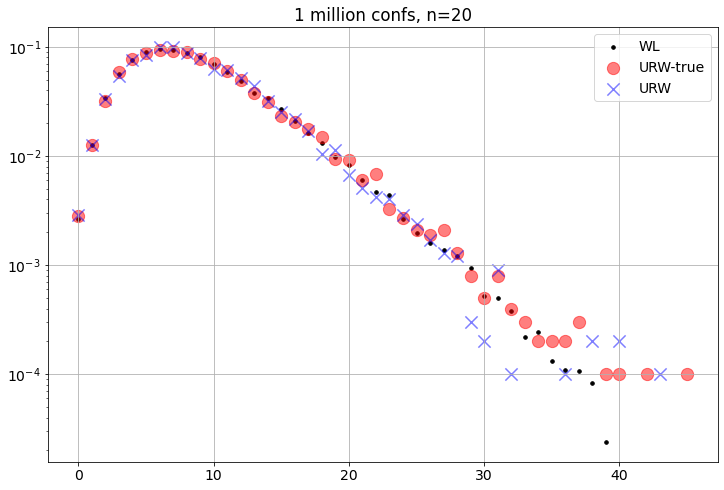

In [564]:
plt.figure(figsize=(12,8))

s = collect_s[-1]
ttt = np.exp(s - max(s));  ttt = [v  if v>10**(-40) else 0 for v in ttt]
t_ = [v/sum(ttt) for v in ttt]
plt.scatter(np.arange(40), t_, facecolor='black', marker='.',s=50, label='WL')
    
    
plt.scatter(bins, counts_,facecolor='red', alpha=0.5, label='URW-true', marker='o', s=150)
plt.scatter(bins11_20, counts_11_20,facecolor='blue', alpha=0.5, label='URW', marker='x', s=150)

plt.yscale('log')
plt.legend()
plt.title('1 million confs, n=%i'%n)
plt.grid()

# N=40

In [565]:
n =40
n_steps = 100000
# bins_40, counts_40 = URW(n=n, n_steps=n_steps)
bins11_40, counts_11_40, out = URW_biased(n=n, n_steps=n_steps, alpha=.10)

0.0 %
0.1 %
0.2 %
0.3 %
0.4 %
0.5 %
0.6 %
0.7000000000000001 %
0.8 %
0.8999999999999999 %
1.0 %
1.0999999999999999 %
1.2 %
1.3 %
1.4000000000000001 %
1.5 %
1.6 %
1.7000000000000002 %
1.7999999999999998 %
1.9 %
2.0 %
2.1 %
2.1999999999999997 %
2.3 %
2.4 %
2.5 %
2.6 %
2.7 %
2.8000000000000003 %
2.9000000000000004 %
3.0 %
3.1 %
3.2 %
3.3000000000000003 %
3.4000000000000004 %
3.5000000000000004 %
3.5999999999999996 %
3.6999999999999997 %
3.8 %
3.9 %
4.0 %
4.1000000000000005 %
4.2 %
4.3 %
4.3999999999999995 %
4.5 %
4.6 %
4.7 %
4.8 %
4.9 %
5.0 %
5.1 %
5.2 %
5.3 %
5.4 %
5.5 %
5.6000000000000005 %
5.7 %
5.800000000000001 %
5.8999999999999995 %
6.0 %
6.1 %
6.2 %
6.3 %
6.4 %
6.5 %
6.6000000000000005 %
6.7 %
6.800000000000001 %
6.9 %
7.000000000000001 %
7.1 %
7.199999999999999 %
7.3 %
7.3999999999999995 %
7.5 %
7.6 %
7.7 %
7.8 %
7.9 %
8.0 %
8.1 %
8.200000000000001 %
8.3 %
8.4 %
8.5 %
8.6 %
8.7 %
8.799999999999999 %
8.9 %
9.0 %
9.1 %
9.2 %
9.3 %
9.4 %
9.5 %
9.6 %
9.700000000000001 %
9.8 %
9.9 %
10

78.60000000000001 %
78.7 %
78.8 %
78.9 %
79.0 %
79.10000000000001 %
79.2 %
79.3 %
79.4 %
79.5 %
79.60000000000001 %
79.7 %
79.80000000000001 %
79.9 %
80.0 %
80.10000000000001 %
80.2 %
80.30000000000001 %
80.4 %
80.5 %
80.60000000000001 %
80.7 %
80.80000000000001 %
80.9 %
81.0 %
81.10000000000001 %
81.2 %
81.3 %
81.39999999999999 %
81.5 %
81.6 %
81.69999999999999 %
81.8 %
81.89999999999999 %
82.0 %
82.1 %
82.19999999999999 %
82.3 %
82.39999999999999 %
82.5 %
82.6 %
82.69999999999999 %
82.8 %
82.89999999999999 %
83.0 %
83.1 %
83.2 %
83.3 %
83.39999999999999 %
83.5 %
83.6 %
83.7 %
83.8 %
83.89999999999999 %
84.0 %
84.1 %
84.2 %
84.3 %
84.39999999999999 %
84.5 %
84.6 %
84.7 %
84.8 %
84.89999999999999 %
85.0 %
85.1 %
85.2 %
85.3 %
85.39999999999999 %
85.5 %
85.6 %
85.7 %
85.8 %
85.9 %
86.0 %
86.1 %
86.2 %
86.3 %
86.4 %
86.5 %
86.6 %
86.7 %
86.8 %
86.9 %
87.0 %
87.1 %
87.2 %
87.3 %
87.4 %
87.5 %
87.6 %
87.7 %
87.8 %
87.9 %
88.0 %
88.1 %
88.2 %
88.3 %
88.4 %
88.5 %
88.6 %
88.7 %
88.8 %
88.9 %

In [ ]:
collect_s_40_1 = WL(n=40, max_overlaps = 40, exclude=(), alpha=5)

sweeping 1
[ 0. 28. 21. 28. 30. 31. 27. 34. 31. 32. 33. 32. 35. 34. 34. 34. 33. 33.
 32. 33. 29. 33. 35. 24. 34. 32. 37. 31.  0. 29. 25. 30.  9.  8.  0. 32.
 17.  0.  0.  0.]
sweeping 2
[ 0. 28. 45. 58. 66. 64. 66. 65. 65. 67. 69. 68. 68. 65. 67. 69. 67. 69.
 65. 69. 67. 64. 64. 66. 67. 66. 61. 64. 65. 47. 51. 30. 31.  8.  0. 32.
 17.  0.  0.  0.]
sweeping 3
[ 0. 68. 81. 80. 88. 88. 90. 89. 89. 89. 89. 89. 88. 91. 89. 90. 89. 86.
 90. 90. 90. 88. 87. 89. 84. 90. 88. 88. 85. 82. 71. 83. 36. 63.  0. 68.
 17. 87. 51.  0.]
sweeping 4
[  0.  98. 100. 112. 112. 113. 116. 116. 118. 118. 115. 118. 115. 116.
 116. 117. 115. 116. 115. 118. 113. 111. 117. 117. 112. 116. 111. 111.
 102. 108.  71. 111.  36.  95.  87.  91.  89.  87.  51.   0.]
sweeping 5
[  0. 134. 126. 137. 135. 139. 141. 142. 142. 144. 139. 142. 142. 144.
 143. 143. 143. 141. 140. 138. 137. 139. 137. 139. 140. 139. 142. 138.
 135. 124. 135. 127. 134. 124. 137.  91.  89.  87.  51.   0.]
sweeping 6
[  0. 154. 150. 164. 162. 164. 165

[117. 475. 450. 456. 456. 450. 458. 460. 456. 453. 454. 454. 451. 452.
 453. 457. 451. 457. 453. 454. 459. 454. 457. 450. 456. 454. 452. 457.
 430. 480. 469. 409. 440. 510. 535. 605. 654. 341. 270. 451.]
sweeping 39
[117. 475. 480. 475. 477. 473. 477. 479. 475. 474. 473. 472. 471. 471.
 472. 478. 470. 473. 473. 472. 479. 469. 469. 480. 468. 475. 482. 471.
 496. 506. 484. 466. 520. 515. 575. 605. 654. 341. 467. 451.]
sweeping 40
[117. 529. 480. 490. 501. 497. 501. 504. 501. 501. 500. 501. 497. 498.
 500. 504. 497. 496. 497. 500. 500. 501. 501. 511. 504. 495. 497. 491.
 519. 520. 511. 499. 520. 576. 599. 652. 692. 341. 509. 451.]
sweeping 41
[117. 533. 515. 519. 520. 521. 526. 530. 523. 522. 523. 526. 521. 519.
 523. 529. 518. 523. 515. 520. 526. 519. 523. 529. 517. 532. 532. 519.
 543. 553. 526. 499. 575. 576. 613. 652. 692. 458. 622. 451.]
sweeping 42
[117. 533. 538. 550. 549. 549. 552. 556. 552. 548. 551. 550. 548. 545.
 550. 552. 545. 547. 545. 549. 551. 542. 552. 550. 546. 545. 556.

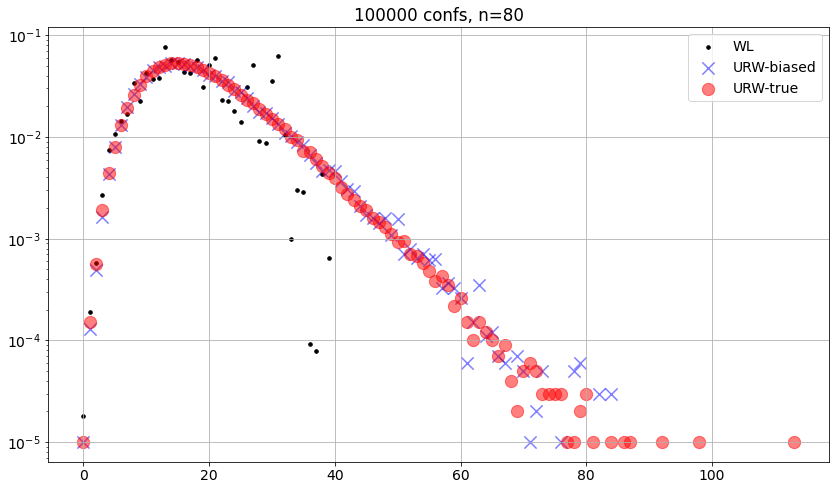

In [714]:
plt.figure(figsize=(14,8))

s = collect_s_40_1[-1]
ttt = np.exp(s - max(s));  ttt = [v  if v>10**(-40) else 0 for v in ttt]
t_ = [v/sum(ttt) for v in ttt]
plt.scatter(np.arange(40), t_, facecolor='black', marker='.',s=50, label='WL')
    
plt.scatter(bins11_40, counts_11_40,facecolor='blue', alpha=0.5, label='URW-biased', marker='x', s=150)

plt.scatter(bins_40, counts_40,facecolor='red', alpha=0.5, label='URW-true', marker='o', s=150)
plt.yscale('log')
plt.legend()
plt.title('%i confs, n=%i'%(n_steps,n))
plt.grid()

In [568]:
bins11_40

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       69, 70, 71, 72, 73, 76, 78, 79, 82, 84])

#  N=80

In [681]:
n=80
n_steps = 100000
bins_80, counts_80 = URW(n=n, n_steps=n_steps)
# bins11_80, counts_11_80, out = URW_biased(n=n, n_steps=n_steps, alpha=70.)

0.0 %
10.0 %
20.0 %
30.0 %
40.0 %
50.0 %
60.0 %
70.0 %
80.0 %
90.0 %


In [694]:
collect_s = WL(n=80, max_overlaps = 30, exclude = (), alpha=70)

sweeping 1


/var/folders/zr/t79_wh252w1d3vc6snt72_lh0000gn/T/ipykernel_24509/3519743255.py:32: RuntimeWarning: overflow encountered in exp
  if np.random.rand() < (w_n/w_o) * np.exp(-alpha*(k_o - k_n)* np.exp(s[o_] - s[n_])):


[  0.   0.   3.  61.  72. 183. 141. 132. 119.  95.  57.  55.  33.  16.
   7.  11.   5.   6.   1.   2.   0.   0.   0.   1.   0.   0.   0.   0.
   0.   0.]
sweeping 2
[  0.   0.  14. 163. 201. 314. 283. 275. 205. 164. 108.  90.  58.  41.
  20.  27.  12.  10.   4.   5.   1.   1.   1.   3.   0.   0.   0.   0.
   0.   0.]
sweeping 3
[  0.   0.  23. 244. 291. 453. 446. 422. 274. 253. 178. 138.  92.  66.
  34.  38.  15.  14.   6.   6.   2.   1.   1.   3.   0.   0.   0.   0.
   0.   0.]
sweeping 4
[  0.   0. 127. 320. 402. 550. 568. 517. 379. 353. 246. 173. 117.  82.
  50.  51.  20.  18.   7.  10.   2.   3.   2.   3.   0.   0.   0.   0.
   0.   0.]
sweeping 5
[  0.   0. 232. 437. 522. 643. 656. 634. 471. 400. 308. 227. 163. 104.
  61.  61.  27.  25.   8.  11.   2.   3.   2.   3.   0.   0.   0.   0.
   0.   0.]
sweeping 6
[  0.   4. 275. 518. 608. 763. 764. 830. 573. 497. 353. 264. 187. 125.
  72.  74.  33.  28.   8.  12.   3.   4.   2.   3.   0.   0.   0.   0.
   0.   0.]
sweeping 7
[  0.   6.

[0.000e+00 1.350e+02 1.293e+03 2.538e+03 3.267e+03 4.255e+03 4.714e+03
 4.067e+03 3.414e+03 2.795e+03 2.031e+03 1.483e+03 1.068e+03 7.190e+02
 4.450e+02 2.980e+02 1.990e+02 1.160e+02 5.600e+01 4.300e+01 2.200e+01
 1.800e+01 1.000e+01 7.000e+00 3.000e+00 3.000e+00 1.000e+00 0.000e+00
 0.000e+00 0.000e+00]
sweeping 34
[0.000e+00 1.760e+02 1.350e+03 2.596e+03 3.344e+03 4.387e+03 4.850e+03
 4.177e+03 3.542e+03 2.876e+03 2.074e+03 1.538e+03 1.090e+03 7.380e+02
 4.640e+02 3.060e+02 2.040e+02 1.200e+02 5.800e+01 4.300e+01 2.300e+01
 2.000e+01 1.000e+01 7.000e+00 3.000e+00 3.000e+00 1.000e+00 0.000e+00
 0.000e+00 0.000e+00]
sweeping 35
[0.000e+00 2.480e+02 1.388e+03 2.678e+03 3.438e+03 4.486e+03 5.007e+03
 4.273e+03 3.650e+03 2.935e+03 2.148e+03 1.594e+03 1.105e+03 7.550e+02
 4.770e+02 3.160e+02 2.110e+02 1.200e+02 5.900e+01 4.400e+01 2.400e+01
 2.000e+01 1.000e+01 7.000e+00 3.000e+00 3.000e+00 1.000e+00 0.000e+00
 0.000e+00 0.000e+00]
sweeping 36
[0.000e+00 2.480e+02 1.446e+03 2.734e+03 3.530

KeyboardInterrupt: 

(0.0, 60.0)

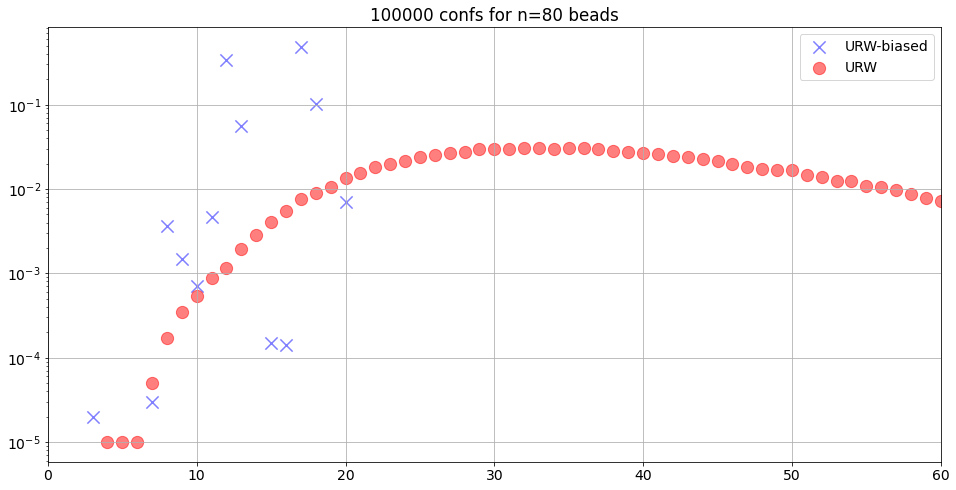

In [682]:
plt.figure(figsize=(16,8))

# s = collect_s[-1]
# ttt = np.exp(s - max(s));  ttt = [v  if v>10**(-40) else 0 for v in ttt]
# t_ = [v/sum(ttt) for v in ttt]
# plt.scatter(np.arange(80), t_, facecolor='black', marker='.',s=50, label='WL')
    
plt.scatter(bins11_80, counts_11_80,facecolor='blue', alpha=0.5, label='URW-biased', marker='x', s=150)

plt.scatter(bins_80, counts_80,facecolor='red', alpha=0.5, label='URW', marker='o', s=150)
plt.yscale('log')
plt.legend()
plt.title('%i confs for n=%i beads'%(n_steps, n))
plt.grid()
# plt.xticks(np.arange(0, max(bins11_80), 5))
plt.xlim(0,60)

In [587]:
a,b = zip(*out)
np.corrcoef(a,b)

array([[1.        , 0.36990546],
       [0.36990546, 1.        ]])

In [649]:
counts_11_80

[0.0001,
 0.0004,
 0.0073,
 0.0075,
 0.0059,
 0.0293,
 0.0077,
 0.2701,
 0.4051,
 0.0148,
 0.0007,
 0.049,
 0.0771,
 0.0086,
 0.1125,
 0.0018,
 0.0021]

# testing uniformity initial and end points for chain regrowing

In [47]:
n = 20
aa=[]; bb=[]
for i in range(10000):
    a = np.random.randint(n)
    b = (a + np.random.randint(1,n//4))%n
    aa.append(a)
    bb.append(b)
v1, b1 = np.histogram(aa,)
v2, b2 = np.histogram(bb)
print(v1, b1)
print(v2,b2)

[1038 1029  959  979  966 1010  985  992 1042 1000] [ 0.   1.9  3.8  5.7  7.6  9.5 11.4 13.3 15.2 17.1 19. ]
[1050  991 1043  988  963  978  998  988  980 1021] [ 0.   1.9  3.8  5.7  7.6  9.5 11.4 13.3 15.2 17.1 19. ]
